# Tutorial 2: Fields and Operators

**Overview:** This tutorials covers the basics of setting up and interacting with field and operator objects in Dedalus.
Dedalus uses field and operator abstractions to implement a symbolic algebra system for representing mathematical expressions and PDEs.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
from dedalus.extras.plot_tools import plot_bot_2d
figkw = {'figsize':(6,4), 'dpi':100}

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 2.1: Fields

### Creating a field

Field objects in Dedalus represent scalar-valued fields defined over a set of bases (or "domain").
A field can be directly instantiated from the `Field` class by passing a distributor, a list of bases, and optionally a name.
They can also be instantiated using the `dist.Field` method.
Let's set up a 2D domain and build a field:

In [3]:
coords = d3.CartesianCoordinates('x', 'y')
dist = d3.Distributor(coords, dtype=np.float64)

xbasis = d3.RealFourier(coords['x'], 64, bounds=(-np.pi, np.pi), dealias=3/2)
ybasis = d3.Chebyshev(coords['y'], 64, bounds=(-1, 1), dealias=3/2)

f = dist.Field(name='f', bases=(xbasis, ybasis))

This field $f$ is a function of both $x$ and $y$, as it is defined with both `xbasis` and `ybasis`.
To make a field that is a function of only $x$ or $y$, we would use `bases=xbasis` or `bases=ybasis`.
To make a field that is spatially constant (independent of $x$ and $y$), we would not pass any bases at all.

### Vector and tensor fields

By default, the `Field` class creates a scalar-valued field.
These can also be instantiated using the `ScalarField` constructor.
Vector-valued fields can be built using the `VectorField` constructor, and passing the coordinate system corresponding to the components you want the vector to have.
Technically this is specifying the [vector bundle](https://en.wikipedia.org/wiki/Vector_bundle) of the field to be the [tangent bundle](https://en.wikipedia.org/wiki/Tangent_bundle) on the specified coordinate system.
Arbitrary-order tensor fields can similarly be built using the `TensorField` constructor and passing a tuple of coordinate systems, which technically describing the [tensor bundle](https://en.wikipedia.org/wiki/Tensor_field#Tensor_bundles) of the tensor field.

**Note**: remember the bases of a field describe its spatial variation, while the vector/tensor bundle describes the components of the field.
For instance, we could have a 2D vector with $x$ and $y$ components that only varies in the $x$ dimension, and hence only has an $x$ basis.
Let's build such a vector field on our domain:

In [4]:
u = dist.VectorField(coords, name='u', bases=xbasis)

### Manipulating field data

Field objects have a variety of methods for transforming their data between different layouts (i.e. grid and coefficient space, and all the layouts in-between). 
The `layout` attribute of each field points to the layout object describing its current transform and distribution state.
We can see that fields are instantiated in coefficient space:

In [5]:
f.layout.grid_space

array([False, False])

Field data can be assigned and retrieved in any layout by indexing a field with that layout object.
In most cases, mixed layouts aren't needed, and it's just the full grid and full coefficient data that are most useful to interact with.
These layouts can be easily accessed using `'g'` and `'c'` keys as shortcuts.

When accessing field data in parallel, each process manipulates just the local data of the globally distributed dataset.
We can therefore easily set a field's grid data in a parallel-safe fashion by using the local grids provided by the domain object:

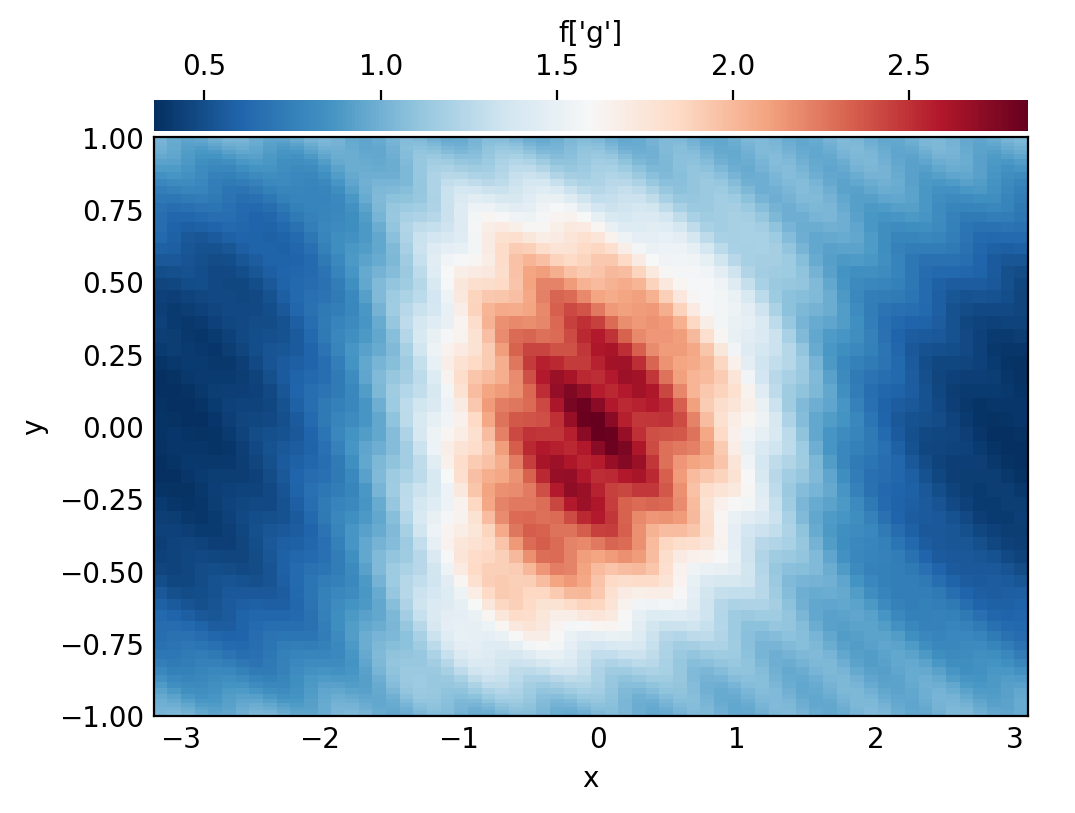

In [6]:
x = dist.local_grid(xbasis)
y = dist.local_grid(ybasis)
f['g'] = np.exp((1-y**2)*np.cos(x+np.cos(x)*y**2)) * (1 + 0.05*np.cos(10*(x+2*y)))

# Plot grid values
plot_bot_2d(f, figkw=figkw, title="f['g']");

We can convert a field to spectral coefficients by requesting the field's data in coefficient space.
This internally triggers an in-place multidimensional spectral transform on the field's data.

/var/folders/gl/8q1_pm2s1490lvyfvm_8yby80000gn/T/ipykernel_4766/1812536267.py:4: RuntimeWarning: divide by zero encountered in log10
  log_mag = lambda xmesh, ymesh, data: (xmesh, ymesh, np.log10(np.abs(data)))


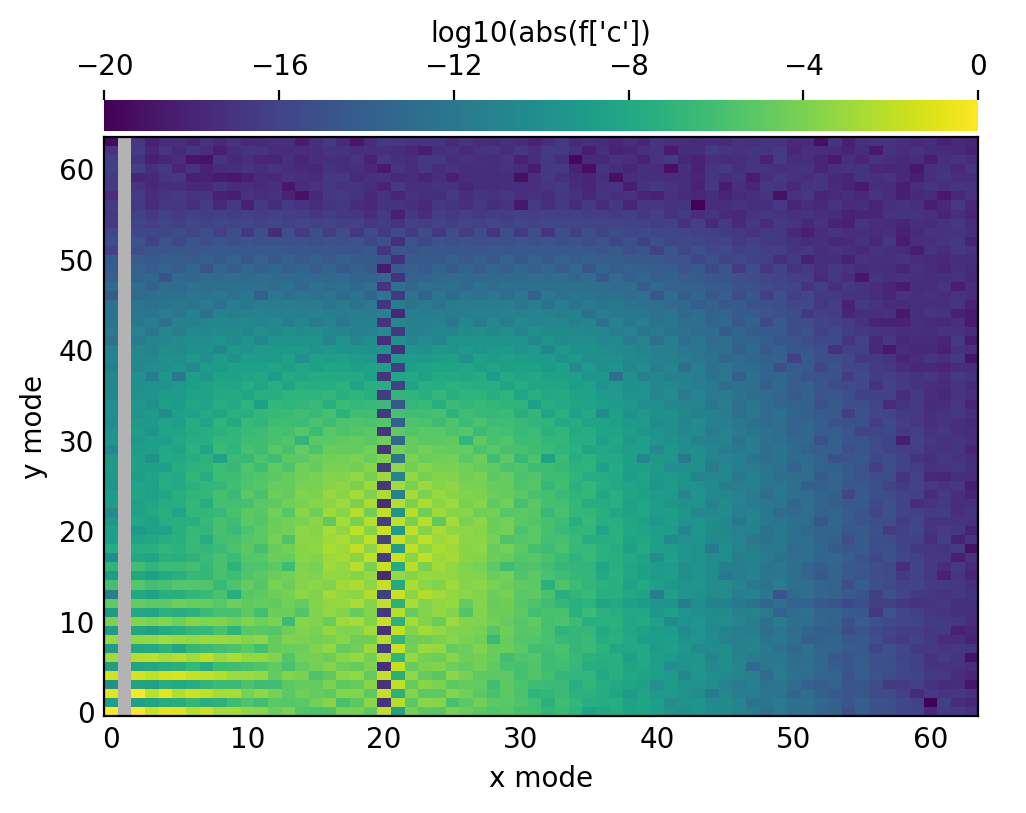

In [7]:
f['c']

# Plot log magnitude of spectral coefficients
log_mag = lambda xmesh, ymesh, data: (xmesh, ymesh, np.log10(np.abs(data)))
plot_bot_2d(f, func=log_mag, clim=(-20, 0), cmap='viridis', title="log10(abs(f['c'])", figkw=figkw);

Examining the spectral coefficients of fields is very useful, since the amplitude of the highest modes indicate the truncation errors in the spectral discretizations of fields.
If these modes are small, like here, then we know the field is well-resolved.


### Vector and tensor components

Vector and tensor fields have higher-dimensional data arrays that include their components in the first axes.
Let's look at the data shape of the vector field we defined:


In [8]:
u['g'].shape

(2, 64, 1)

The first axis is size 2, corresponding to the two vector components ($x$ and $y$).
The remaining physical shape is $(64, 1)$, since this field is constant along the $y$ direction (it was only defined with an $x$ basis).

In grid space, the components of vector and tensor fields are simply those corresponding to the unit vectors of the specified tangent spaces (here $e_x$ and $e_y$).
For cartesian domains, the same is true in coefficient space.
For other domains, however, the components may be recombined during the spectral transforms, so the component-wise data is not as easy to interpret.
For this reason, it's typically recommended to initialize vector and tensor data in grid space.

### Field scale factors

The `change_scales` method on a field is used to change the scaling factors used when transforming the field's data into grid space.
When setting a field's data using grid arrays, shape errors will result if there is a mismatch between the field and grid's scale factors.

Large scale factors can be used to interpolate the field data onto a high-resolution grid, while small scale factors can be used to view a lower-resolution grid representation of a field.
**Beware:** using scale factors less than 1 will result in a loss of data when transforming to grid space.

Let's take a look at a high-resolution sampling of our field, by increasing the scales.

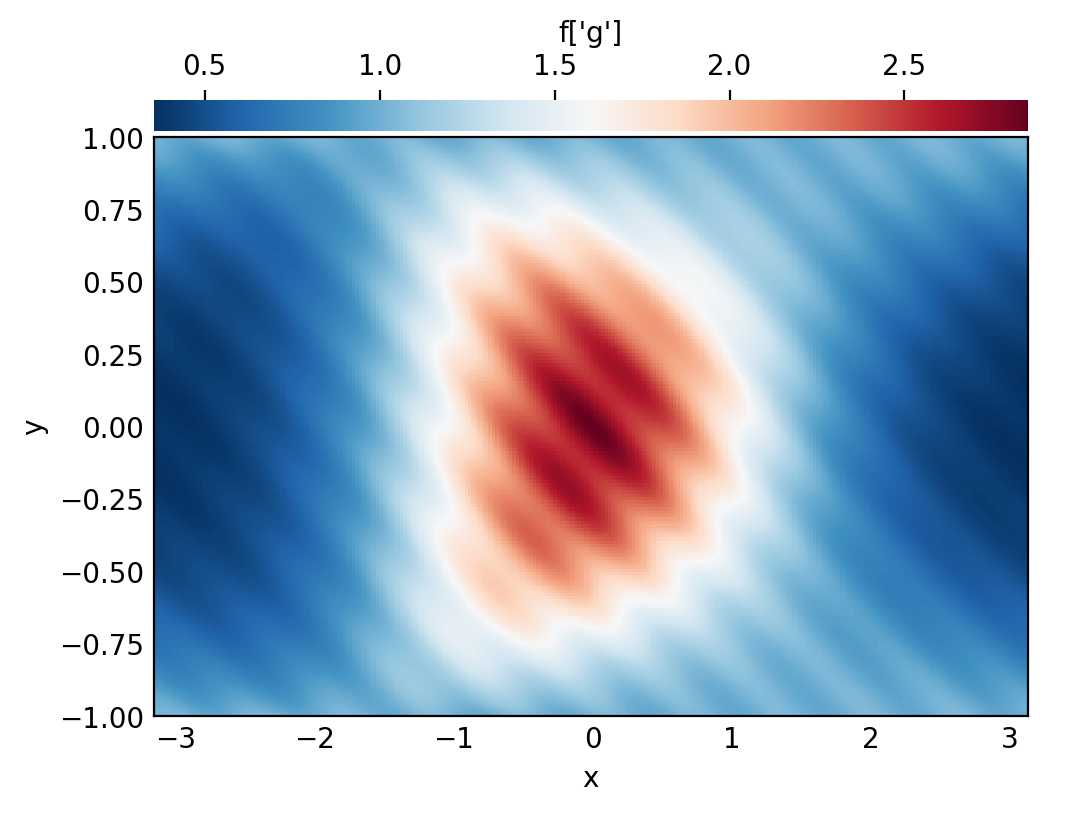

In [9]:
f.change_scales(4)

# Plot grid values
f['g']
plot_bot_2d(f, title="f['g']", figkw=figkw);

## 2.2: Operators

### Arithmetic with fields

Mathematical operations on fields, including arithmetic, differentiation, integration, and interpolation, are represented by `Operator` classes.
An instance of an operator class represents a specific mathematical expression, and provides an interface for the deferred evaluation of that expression with respect to it's potentially evolving arguments.

Arithmetic operations between fields, or fields and scalars, are produced simply using Python's infix operators for arithmetic.
Let's start with a simple affine transformation of our field:

In [10]:
g_op = 1 - 2*f
print(g_op)

C(C(1)) + -1*2*f


The object we get is not another field, but an operator object representing the addition of 1 to the multiplication of -1, 2, and our field.
To actually compute this operation, we use the `evaluate` method, which returns a new field with the result.
The dealias scale factors set during basis instantiation are used for the evaluation of all operators.

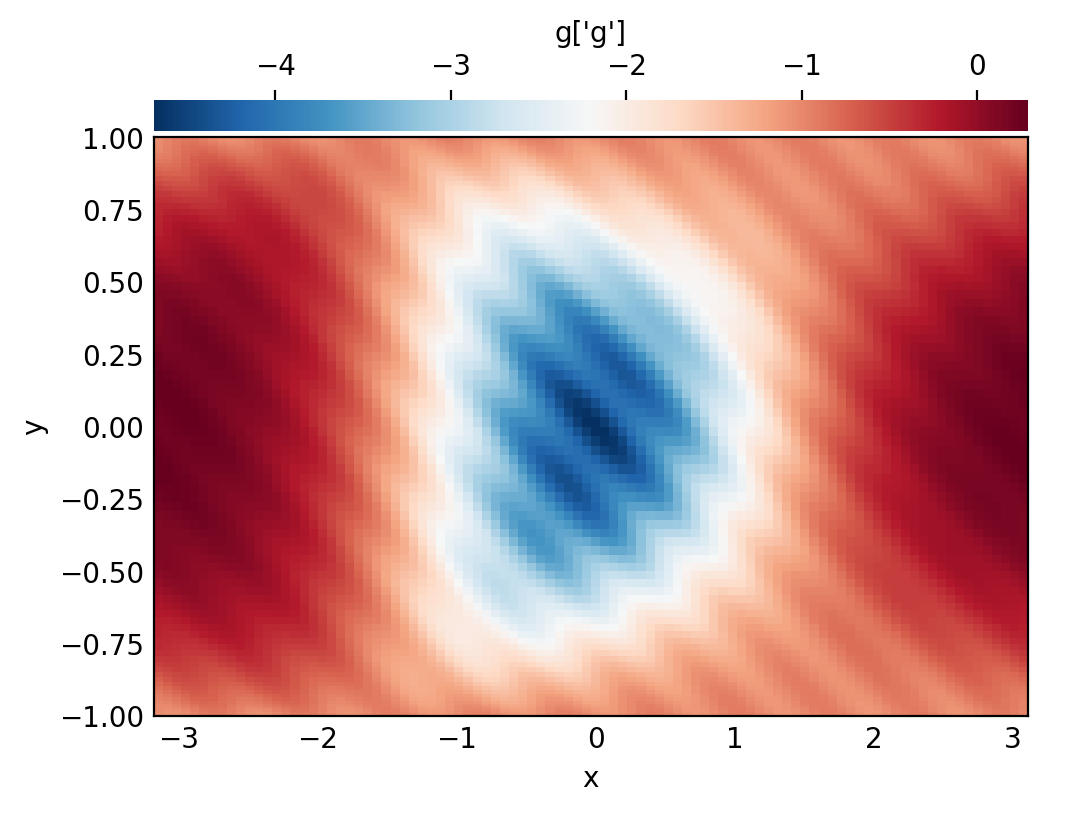

In [11]:
g = g_op.evaluate()

# Plot grid values
g['g']
plot_bot_2d(g, title="g['g']", figkw=figkw);

### Building expressions

Operator instances can be passed as arguments to other operators, building trees that represent more complicated expressions:

In [12]:
h_op = 1 / np.cosh(g_op + 2.5)
print(h_op)

Pow(cosh(C(C(1)) + -1*2*f + C(C(2.5))), -1)


Reading these signatures can be a little cumbersome, but we can plot the operator's structure using a helper from `dedalus.tools`:

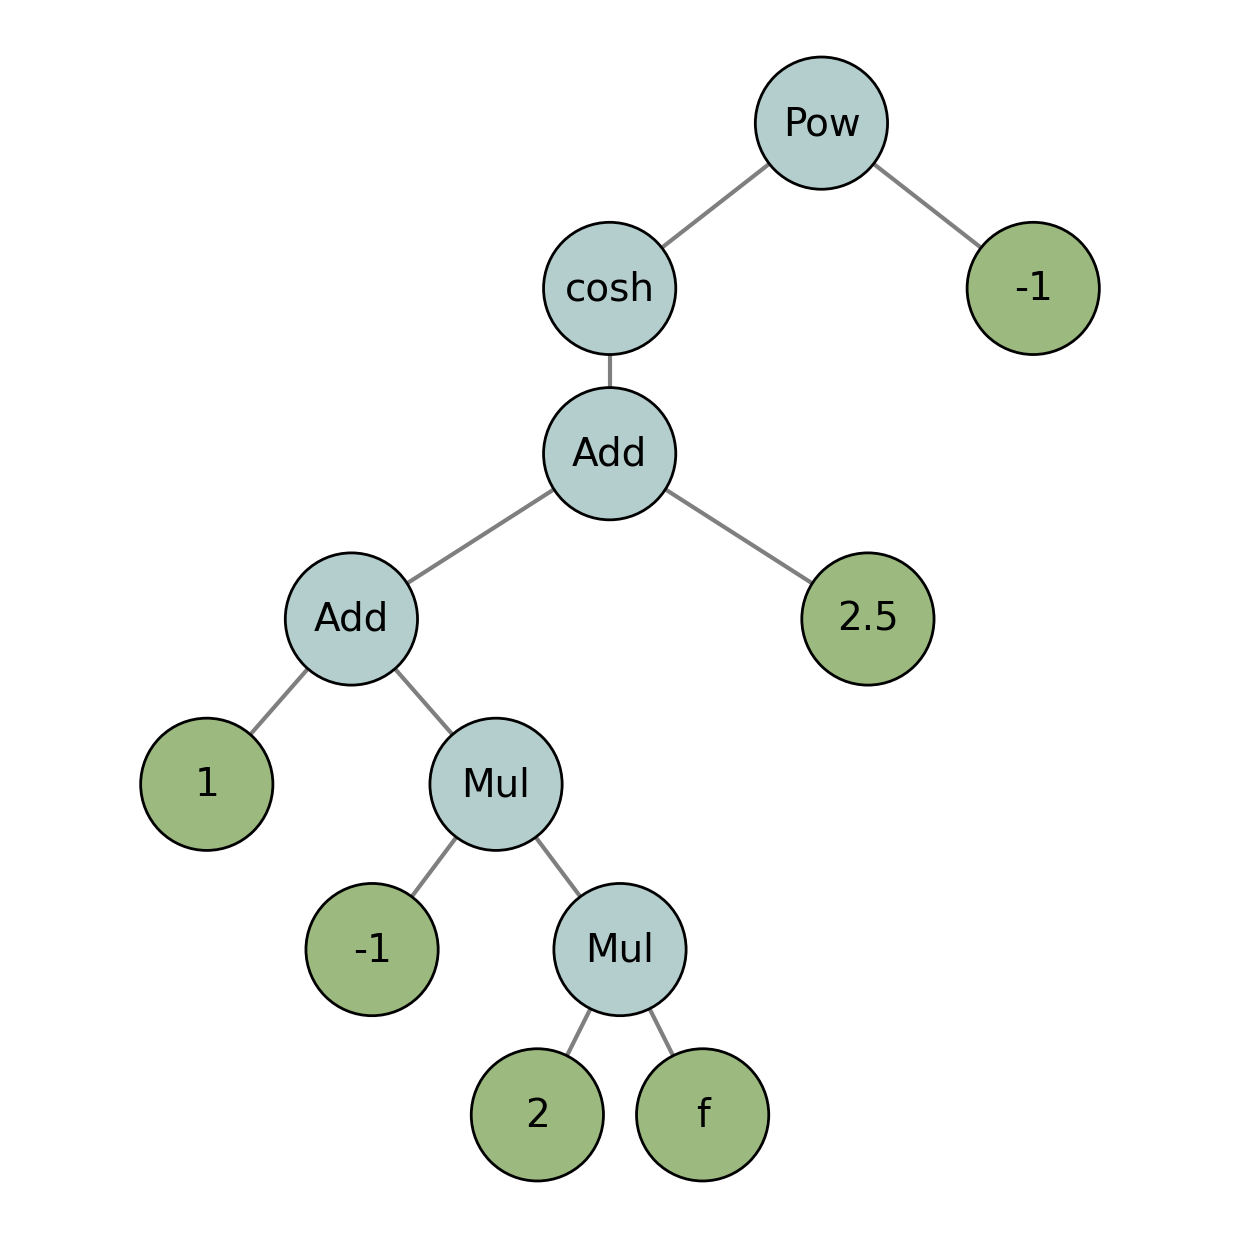

In [13]:
from dedalus.tools.plot_op import plot_operator
plot_operator(h_op, figsize=6, fontsize=14, opsize=0.4)

And evaluating it:

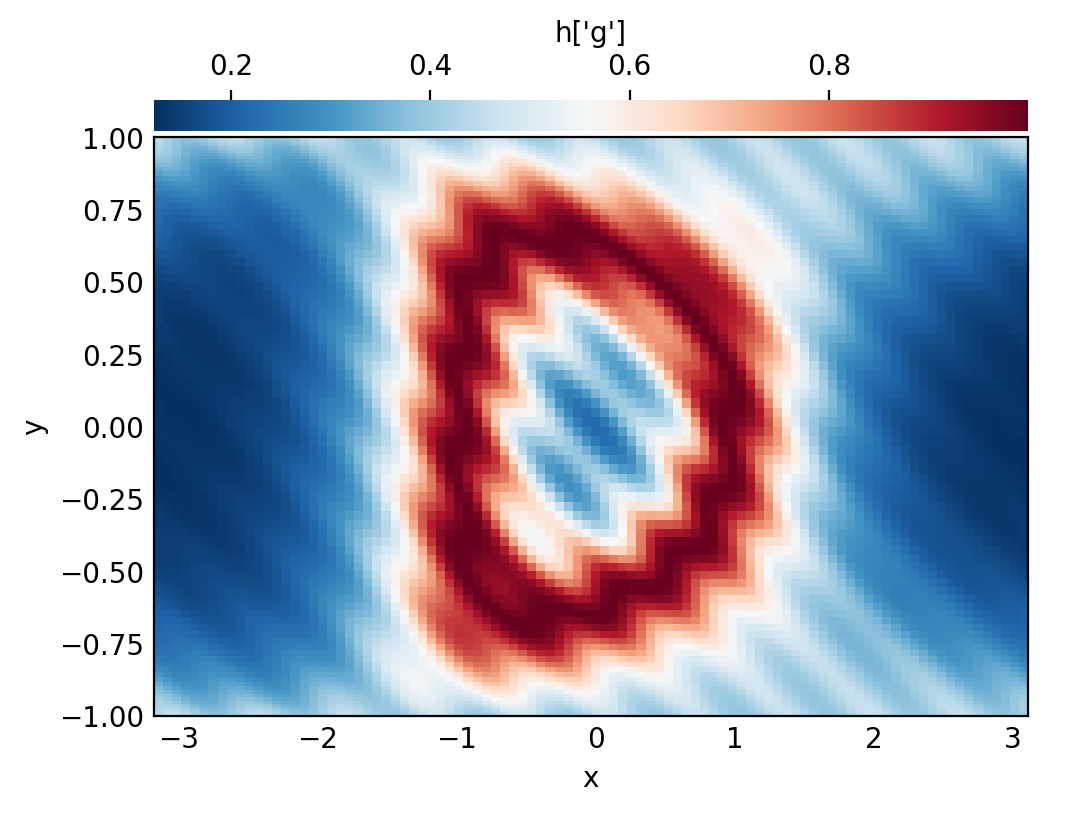

In [14]:
h = h_op.evaluate()

# Plot grid values
h['g']
plot_bot_2d(h, title="h['g']", figkw=figkw);

### Deferred evaluation

A key point is that the operator objects symbolically represent an operation on the field arguments, and are evaluated using deferred evaluation.
If we change the data of the field arguments and re-evaluate an operator, we get a new result.

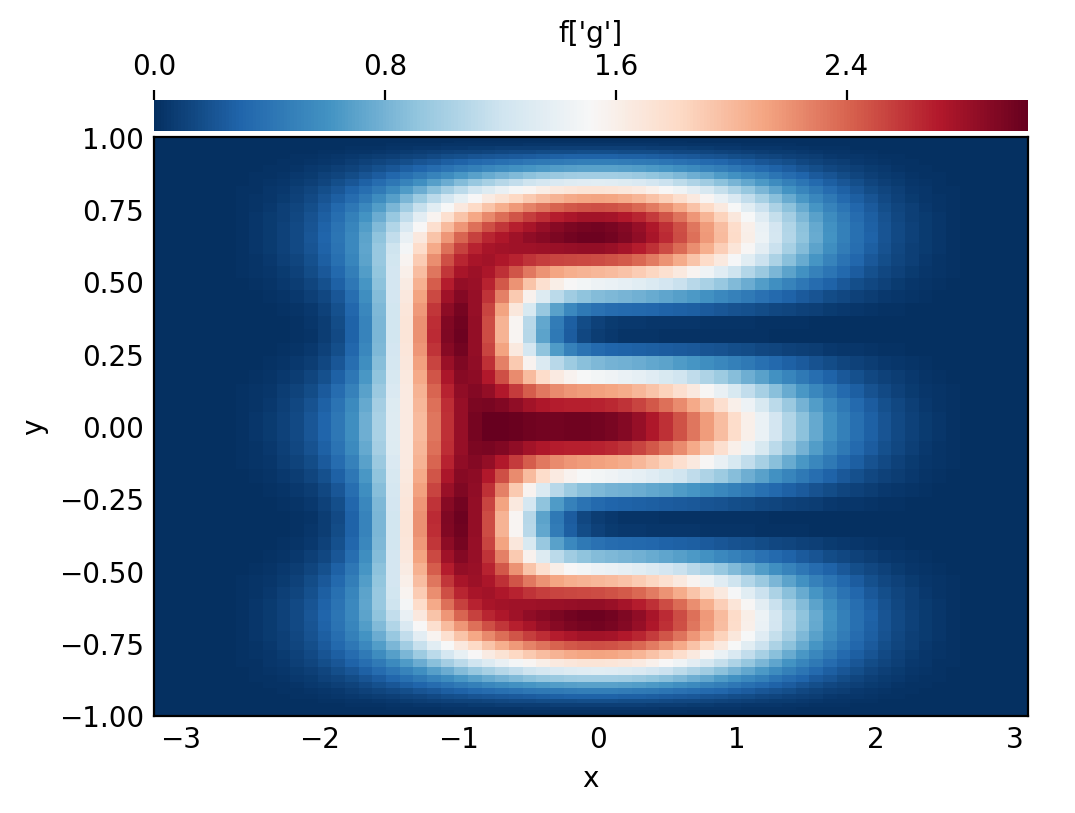

In [15]:
# Change scales back to 1 to build new grid data
f.change_scales(1)
f['g'] = 3*np.cos(1.5*np.pi*y)**2 * np.cos(x/2)**4 + 3*np.exp(-((2*x+2)**2 + (4*y+4/3)**2)) + 3*np.exp(-((2*x+2)**2 + (4*y-4/3)**2))

# Plot grid values
f['g']
plot_bot_2d(f, title="f['g']", figkw=figkw);

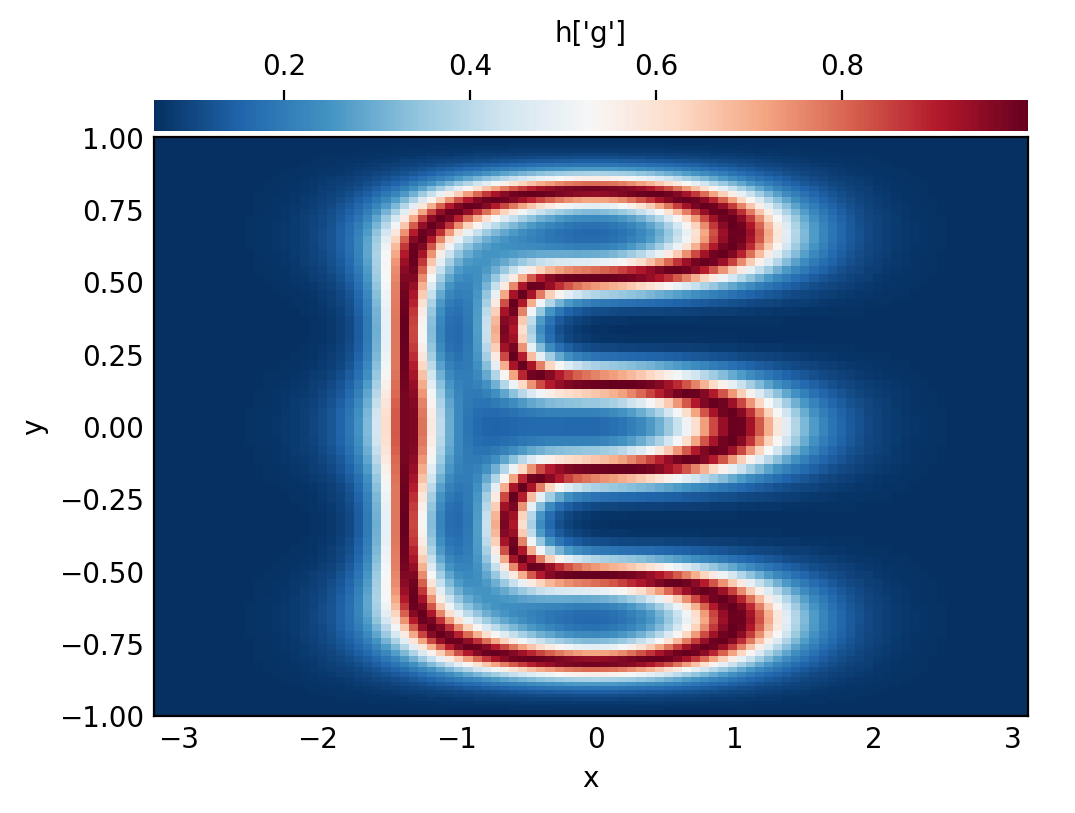

In [16]:
h = h_op.evaluate()

# Plot grid values
h['g']
plot_bot_2d(h, title="h['g']", figkw=figkw);

### Differential operators

Operators are also used for differentiation fields.
Partial derivative operators are implemented for one-dimensional bases by using the `Differentiate` operator and specifying the coordinate for differentiating:

In [17]:
fx = d3.Differentiate(f, coords['x'])

For multidimensional problems, it's more common to use the built in vector calculus operators:

* `Gradient` for arbitrary fields.
* `Divergence` for arbitrary vector/tensor fields.
* `Curl` for vector fields.
* `Laplacian`, defined as the divergence of the gradient, for arbitrary fields.

A coordinate system can optionally be specified as the tangent bundle for the gradient and Laplacian (defaulting to the distributor's coordinate system), and a tensor index can optionally be specified for the divergence (defaulting to 0).
The gradient of a rank $r$ tensor field will be rank $r+1$, etc.

In [18]:
lap_f = d3.Laplacian(f).evaluate()
grad_f = d3.Gradient(f).evaluate()
print('f shape:', f['g'].shape)
print('Grad(f) shape:', grad_f['g'].shape)
print('Lap(f) shape:', lap_f['g'].shape)

div_grad_f = d3.Divergence(d3.Gradient(f)).evaluate()
print('Lap(f) is Div(Grad(f)):', np.allclose(lap_f['g'], div_grad_f['g']))

f shape: (96, 96)
Grad(f) shape: (2, 96, 96)
Lap(f) shape: (96, 96)
Lap(f) is Div(Grad(f)): True


### Tensor operators

Several operators are defined for manipulating the components of tensor fields, including:

* `Trace` for contracting two specified indices (defaulting to 0 and 1).
* `TransposeComponents` for swapping two specified indices (defaulting to 0 and 1).
* `Skew` for taking a 90-degree positive rotation of 2D vector fields.

In [19]:
grad_u = d3.Gradient(u)
transpose_grad_u = d3.TransposeComponents(grad_u)

### Integrals and averages

Integrals and averages of scalar fields over coordinates / coordinate systems are computed with the `Integrate` and `Average` operators.

In [20]:
# Total integral of the field
f_int = d3.Integrate(f, ('x', 'y'))
print('f integral:', f_int.evaluate()['g'])

# Average of the field
f_ave = d3.Average(f, ('x', 'y'))
print('f average:', f_ave.evaluate()['g'])

f integral: [[9.42458659]]
f average: [[0.74998477]]


### Interpolation

Interpolation along a coordinate is computed with the `Interpolate` operator, or using the `__call__` method on fields/operators, with keywords specifying the coordinate and position.
The strings `'left'`, `'right'`, and `'center'` can be used to refer to the endpoints and middle of 1D intervals, respectively, for convenience.

In [21]:
f00 = f(x=0, y=0)
print('f(0,0):', f00.evaluate()['g'])

f(0,0): [[3.01857352]]
